# **Fisher Unlearning Algorithm**

# **Colab and Drive Setup**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

In [ ]:
import os
os.chdir("/content/gdrive/My Drive/my-dl-assignment-google-drive-folder")

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
import torch.optim as optim
import random
import gzip


%matplotlib inline
%load_ext autoreload
%autoreload 2

# **Classifier Model Architecture**

In [ ]:
NUM_CLASSES = 10

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        # First layer should accept 3 channels of 227x227 images
        self.fc1 = nn.Linear(3 * 227 * 227, 256)  # 3 channels * 227 * 227 pixels
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        # Flatten the input tensor, now it will have shape [batch_size, 3 * 227 * 227]
        # x = x.view(x.shape[0], -1)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

# **Dataset Import and Loading Data**

In [ ]:
# Setting up reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Transformation for data
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel RGB
    transforms.Resize((227, 227)),  # Resize images to 227x227
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

In [ ]:
# Load full MNIST training and test datasets
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split full_train_dataset into train and validation sets
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

In [ ]:
# DataLoaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# **Visualizing the Data**



In [ ]:
# Define MNIST classes
MNIST_CLASSES = (
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'
)

In [ ]:
def load_mnist(path, kind='train'):
    """Load MNIST data from `path`."""
    labels_path = os.path.join(path, f'{kind}-labels-idx1-ubyte.gz')
    images_path = os.path.join(path, f'{kind}-images-idx3-ubyte.gz')

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
X_train, Y_train = load_mnist('./data/MNIST', kind='train')
mask = list(range(len(train_dataset)))
X_train = X_train[mask]

for i in range(10):
    idx = np.random.randint(0, len(train_dataset))
    img, label = X_train[idx], Y_train[idx]
    img = img.reshape((28, 28))
    plt.figure(figsize = (2,2))
    plt.title(f'{MNIST_CLASSES[label]}')
    plt.imshow(img)

# **Training and Testing Functions**



In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    losses_plot = []
    for i, (images, labels) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        logits = classifier(images)

        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        losses.append(loss)
        losses_plot.append(loss.detach().item())

    return torch.stack(losses).mean().item(), losses_plot

In [ ]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0))
        y_score = np.zeros((0,10))
        for i, (images, labels) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss.item())
        aps = []

        B = y_true.shape[0]
        y_true_one_hot = np.zeros((B, 10))
        y_true_one_hot[np.arange(B), y_true.astype(np.int16)] = 1

        for i in range(10):
            ap = average_precision_score(y_true_one_hot[:, i], y_score[:, i])
            if print_ind_classes:
                print(f'-------  Class: {i}     AP: {ap:>8.4f}  -------')
            aps.append(ap)

        mAP = np.mean(aps)
        test_loss = np.mean(losses)
        print('mAP: {0:.4f}'.format(mAP))
        print('Avg loss: {}'.format(test_loss))

    return mAP, test_loss, aps

# **Model Setup and Training Loop**



In [ ]:
classifier = Classifier().to(device)
# You can can use this function to reload a network you have already saved previously
# classifier.load_state_dict(torch.load('./classifier.pth'))

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)


In [ ]:
# Training Loop
NUM_EPOCHS = 5
TEST_FREQUENCY = 1

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Starting epoch number {epoch}")
    train_loss, losses = train_classifier(train_loader, classifier, criterion, optimizer)
    print(f"Loss for Training on Epoch {epoch} is {train_loss}")
    if epoch % TEST_FREQUENCY == 0:
        mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
        print("Evaluating classifier")
        print(f"Mean Precision Score for Testing on Epoch {epoch} is {mAP_val}")


Starting epoch number 1
Loss for Training on Epoch 1 is 0.7352168847024441
-------  Class: 0     AP:   0.9913  -------
-------  Class: 1     AP:   0.9903  -------
-------  Class: 2     AP:   0.9565  -------
-------  Class: 3     AP:   0.9598  -------
-------  Class: 4     AP:   0.9798  -------
-------  Class: 5     AP:   0.9332  -------
-------  Class: 6     AP:   0.9871  -------
-------  Class: 7     AP:   0.9773  -------
-------  Class: 8     AP:   0.9382  -------
-------  Class: 9     AP:   0.9565  -------
mAP: 0.9670
Avg loss: 0.31293721000353497
Evaluating classifier
Mean Precision Score for Testing on Epoch 1 is 0.9669940465419737
Starting epoch number 2
Loss for Training on Epoch 2 is 0.25230124421417716
-------  Class: 0     AP:   0.9936  -------
-------  Class: 1     AP:   0.9960  -------
-------  Class: 2     AP:   0.9867  -------
-------  Class: 3     AP:   0.9764  -------
-------  Class: 4     AP:   0.9844  -------
-------  Class: 5     AP:   0.9739  -------
-------  Class:

In [ ]:
# Save the classifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
torch.save(classifier.state_dict(), './classifier.pth')

# **Testing Model**



In [ ]:
mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

-------  Class: 0     AP:   0.9950  -------
-------  Class: 1     AP:   0.9967  -------
-------  Class: 2     AP:   0.9691  -------
-------  Class: 3     AP:   0.9802  -------
-------  Class: 4     AP:   0.9716  -------
-------  Class: 5     AP:   0.9818  -------
-------  Class: 6     AP:   0.9908  -------
-------  Class: 7     AP:   0.9864  -------
-------  Class: 8     AP:   0.9816  -------
-------  Class: 9     AP:   0.9663  -------
mAP: 0.9819
Avg loss: 0.22949393203831278


# **Fisher Unlearning**



In [ ]:
def compute_fisher_information_matrix(model, data_loader, loss_fn, device="cpu"):
    fisher_matrix = {}
    for name, param in model.named_parameters():
        fisher_matrix[name] = torch.zeros_like(param).to(device)

    for data, labels in data_loader:
        data, labels = data.to(device), labels.to(device)
        model.zero_grad()
        outputs = model(data)
        loss = loss_fn(outputs, labels)
        loss.backward()

        for name, param in model.named_parameters():
            fisher_matrix[name] += param.grad.data ** 2

    # Normalize by dataset size
    for name in fisher_matrix:
        fisher_matrix[name] /= len(data_loader.dataset)

    return fisher_matrix


In [ ]:
loss_fn = nn.CrossEntropyLoss()
fim = compute_fisher_information_matrix(classifier, train_loader, loss_fn, device=device)
print(fim)

{'fc1.weight': tensor([[4.6979e-09, 4.6979e-09, 4.6979e-09,  ..., 4.6979e-09, 4.6979e-09,
         4.6979e-09],
        [8.1011e-09, 8.1011e-09, 8.1011e-09,  ..., 8.1011e-09, 8.1011e-09,
         8.1011e-09],
        [2.1994e-09, 2.1994e-09, 2.1994e-09,  ..., 2.1994e-09, 2.1994e-09,
         2.1994e-09],
        ...,
        [6.4026e-09, 6.4026e-09, 6.4026e-09,  ..., 6.4026e-09, 6.4026e-09,
         6.4026e-09],
        [6.4677e-09, 6.4677e-09, 6.4677e-09,  ..., 6.4677e-09, 6.4677e-09,
         6.4677e-09],
        [2.6324e-09, 2.6324e-09, 2.6324e-09,  ..., 2.6324e-09, 2.6324e-09,
         2.6324e-09]], device='cuda:0'), 'fc1.bias': tensor([4.6979e-09, 8.1011e-09, 2.1994e-09, 1.6453e-09, 9.1212e-09, 9.5145e-09,
        1.6085e-09, 8.5203e-09, 8.8354e-09, 5.9153e-09, 2.5318e-11, 1.1361e-09,
        3.1468e-09, 2.1220e-09, 2.9577e-09, 8.5443e-10, 1.2545e-09, 1.2371e-09,
        1.3767e-08, 1.0612e-08, 8.1301e-09, 6.6004e-09, 1.4916e-08, 9.7808e-10,
        0.0000e+00, 6.8347e-09, 1.1219e

In [ ]:
subset_to_unlearn = torch.utils.data.Subset(train_dataset, list(range(10000)))  # Select the first 10000 examples to unlearn
unlearn_loader = DataLoader(subset_to_unlearn, batch_size=10, shuffle=False)

In [ ]:
def fisher_unlearning(model, fim, data_to_unlearn, loss_fn, sigma=0, device="cpu"):
    """
    Applies Fisher unlearning as per Golatkar et al. (2019) to all Fisher Information values.

    Arguments:
    - model: The trained model to be unlearned.
    - fim: Fisher Information matrix for each model parameter.
    - data_to_unlearn: The data subset to be unlearned.
    - loss_fn: The loss function used to compute the gradients.
    - sigma: Noise scaling parameter.
    - device: Device to use for computation (e.g., 'cpu' or 'cuda').

    Returns:
    - Updated model after unlearning.
    """
    model.to(device)  # Ensure model is on the correct device
    model.train()  # Set the model to training mode
    optimizer = optim.SGD(model.parameters(), lr=0.01)  # Define an optimizer

    # Iterate over data to unlearn
    for data, labels in data_to_unlearn:
        data, labels = data.to(device), labels.to(device)  # Move data and labels to the correct device
        optimizer.zero_grad()  # Zero the gradients

        outputs = model(data)  # Get model output
        loss = loss_fn(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagate the loss

        # Loop over model parameters
        for name, param in model.named_parameters():
            if param.grad is not None:  # Ensure there are gradients to work with
                fim_values = fim[name]  # Get Fisher Information values for the current parameter

                # Adjust all parameters using the inverse of the Fisher Information values
                fim_inv = 1.0 / (fim_values + 1e-6)  # Add small value for numerical stability
                adjustment = fim_inv * param.grad.data  # Compute the adjustment
                param.data -= adjustment  # Apply the adjustment to the parameter

                # Optionally add noise if sigma > 0
                if sigma > 0:
                    noise = sigma * torch.randn_like(param.data).to(device)
                    param.data += fim_inv * noise  # Add noise scaled by Fisher Information

    # Return the updated model after unlearning
    return model


In [ ]:
unlearned_model = fisher_unlearning(classifier, fim, unlearn_loader, loss_fn, sigma=0.1, device=device)
unlearned_model.to(device)

In [ ]:
# File path to save the model
# Save only the model's state dictionary (recommended)
torch.save(unlearned_model.state_dict(), "./unlearn_classifier.pth")

# **Evaluation of Unlearning**



In [ ]:

# Evaluation Function (Ensuring consistency)
def evaluate_models(model, data_loader, device="cpu"):
    model.to(device)  # Ensure model is on the correct device
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)  # Ensure data and labels are on the same device
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())  # Move predictions to CPU for evaluation
            all_labels.extend(labels.cpu().numpy())  # Move labels to CPU for evaluation
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [ ]:
# Evaluate the unlearning model
print("Evaluating the unlearning model...")
metrics = evaluate_models(unlearned_model, test_loader, device=device)

Evaluating the unlearning model...
Accuracy: 0.0958


In [ ]:
model_untrained = Classifier()
model_untrained.to(device)

# Set the model to evaluation mode
model_untrained.eval()

In [ ]:
print("Evaluating the Untrained model...")
metrics = evaluate_models(model_untrained, test_loader, device=device)

Evaluating the Untrained model...
Accuracy: 0.1021


In [ ]:
# Evaluate the trained and finedtuned model
print("Evaluating the Trained model...")
metrics = evaluate_models(classifier, test_loader, device=device)

Evaluating the Trained model...
Accuracy: 0.9295


# **Naive Retraining**



In [ ]:
 # Define the indices for the remaining data
remaining_indices = list(range(10000, len(train_dataset)))  # Exclude the first 10000 examples
remaining_dataset = torch.utils.data.Subset(train_dataset, remaining_indices)

# Create a DataLoader for the remaining dataset
remaining_loader = DataLoader(remaining_dataset, batch_size=64, shuffle=True)

In [ ]:
NUM_EPOCHS = 5
TEST_FREQUENCY = 1

for epoch in range(1, NUM_EPOCHS+1):
    print("Starting epoch number " + str(epoch))
    train_loss, losses = train_classifier(remaining_loader, model_untrained, criterion, optimizer)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    if(epoch%TEST_FREQUENCY==0):
        mAP_val, val_loss, _ = test_classifier(val_loader, model_untrained, criterion)
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))


Starting epoch number 1
Loss for Training on Epoch 1 is 0.5358046293258667
-------  Class: 0     AP:   0.9920  -------
-------  Class: 1     AP:   0.9947  -------
-------  Class: 2     AP:   0.9768  -------
-------  Class: 3     AP:   0.9695  -------
-------  Class: 4     AP:   0.9807  -------
-------  Class: 5     AP:   0.9617  -------
-------  Class: 6     AP:   0.9812  -------
-------  Class: 7     AP:   0.9886  -------
-------  Class: 8     AP:   0.9584  -------
-------  Class: 9     AP:   0.9651  -------
mAP: 0.9769
Avg loss: 0.2567658106564195
Evaluating classifier
Mean Precision Score for Testing on Epoch 1 is 0.9768652356354369
Starting epoch number 2
Loss for Training on Epoch 2 is 0.2775103747844696
-------  Class: 0     AP:   0.9934  -------
-------  Class: 1     AP:   0.9961  -------
-------  Class: 2     AP:   0.9812  -------
-------  Class: 3     AP:   0.9811  -------
-------  Class: 4     AP:   0.9825  -------
-------  Class: 5     AP:   0.9758  -------
-------  Class: 6

In [ ]:
NUM_EPOCHS = 5
TEST_FREQUENCY = 1

for epoch in range(1, NUM_EPOCHS+1):
    print("Starting epoch number " + str(epoch))
    train_loss, losses = train_classifier(train_loader, unlearned_model, criterion, optimizer)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    if(epoch%TEST_FREQUENCY==0):
        mAP_val, val_loss, _ = test_classifier(val_loader, unlearned_model, criterion)
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))

Starting epoch number 1
Loss for Training on Epoch 1 is 0.28647446632385254
-------  Class: 0     AP:   0.9979  -------
-------  Class: 1     AP:   0.9968  -------
-------  Class: 2     AP:   0.9748  -------
-------  Class: 3     AP:   0.9770  -------
-------  Class: 4     AP:   0.9828  -------
-------  Class: 5     AP:   0.9840  -------
-------  Class: 6     AP:   0.9956  -------
-------  Class: 7     AP:   0.9895  -------
-------  Class: 8     AP:   0.9837  -------
-------  Class: 9     AP:   0.9624  -------
mAP: 0.9844
Avg loss: 0.28818020472923916
Evaluating classifier
Mean Precision Score for Testing on Epoch 1 is 0.9844465772923732
Starting epoch number 2
Loss for Training on Epoch 2 is 0.28647446632385254
-------  Class: 0     AP:   0.9979  -------
-------  Class: 1     AP:   0.9968  -------
-------  Class: 2     AP:   0.9748  -------
-------  Class: 3     AP:   0.9770  -------
-------  Class: 4     AP:   0.9828  -------
-------  Class: 5     AP:   0.9840  -------
-------  Class

# **Results Unlearning**



In [ ]:
def compute_accuracy(model, data_loader, device="cpu"):
    """
    Computes the accuracy of a model on a given dataset.

    Arguments:
    - model: The model to be evaluated.
    - data_loader: The DataLoader containing the dataset.
    - device: Device to run the model on (e.g., "cpu" or "cuda").

    Returns:
    - accuracy (float): The accuracy of the model on the dataset.
    """
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for inference
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            # Forward pass
            outputs = model(data)

            # Get predicted labels
            _, predicted = torch.max(outputs, 1)

            # Update correct and total
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

In [ ]:
def compute_kl_divergence(p, q, epsilon=1e-8):
    """
    Compute the Kullback-Leibler divergence between two probability distributions using PyTorch.

    Arguments:
    - p: The first probability distribution (e.g., unlearned model).
    - q: The second probability distribution (e.g., retrained model).
    - epsilon: A small constant to avoid log(0).

    Returns:
    - kl_div: The computed KL divergence.
    """
    p = p + epsilon  # Add small epsilon for numerical stability
    q = q + epsilon  # Add small epsilon for numerical stability

    # Normalize the probability distributions
    p = p / p.sum(dim=-1, keepdim=True)
    q = q / q.sum(dim=-1, keepdim=True)

    # Compute KL divergence using the formula: p * log(p / q)
    kl_div = F.kl_div(p.log(), q, reduction='batchmean')
    return kl_div

In [ ]:
def plot_accuracy_gap_and_kl(unlearned_model, retrained_model, data_loader, device="cpu"):
    """
    Plots the accuracy gap between the unlearned model and the retrained model for each batch,
    as well as the KL divergence at each batch.

    Arguments:
    - unlearned_model: The unlearned model to be evaluated.
    - retrained_model: The retrained model to be evaluated.
    - data_loader: The DataLoader containing the dataset.
    - device: Device to run the model on (e.g., "cpu" or "cuda").
    """
    accuracy_gaps = []
    kl_divergences = []

    unlearned_model.eval()  # Set the model to evaluation mode
    retrained_model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient computation for inference
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)

            # Forward pass for both models
            unlearned_outputs = unlearned_model(data)
            retrained_outputs = retrained_model(data)

            # Convert logits to probabilities (softmax output)
            unlearned_prob = F.softmax(unlearned_outputs, dim=-1)
            retrained_prob = F.softmax(retrained_outputs, dim=-1)

            # Compute accuracy for both models
            unlearned_acc = (unlearned_outputs.argmax(dim=1) == labels).float().mean().item()
            retrained_acc = (retrained_outputs.argmax(dim=1) == labels).float().mean().item()

            # Store the accuracy gap and the KL divergence for this batch
            accuracy_gaps.append(retrained_acc - unlearned_acc)
            kl_divergences.append(compute_kl_divergence(unlearned_prob, retrained_prob).item())

    # Plot the accuracy gap
    plt.figure(figsize=(10, 6))
    plt.subplot(2, 1, 1)
    plt.plot(accuracy_gaps, label="Accuracy Gap (Retrained - Unlearned)", color='orange')
    plt.xlabel('Batch Index')
    plt.ylabel('Accuracy Gap')
    plt.title('Accuracy Gap Between Retrained and Unlearned Model (per Batch)')
    plt.legend()

    # Plot the KL Divergence
    plt.subplot(2, 1, 2)
    plt.plot(kl_divergences, label="KL Divergence", color='blue')
    plt.xlabel('Batch Index')
    plt.ylabel('KL Divergence')
    plt.title('KL Divergence Between Retrained and Unlearned Model (per Batch)')
    plt.legend()

    plt.tight_layout()
    plt.show()


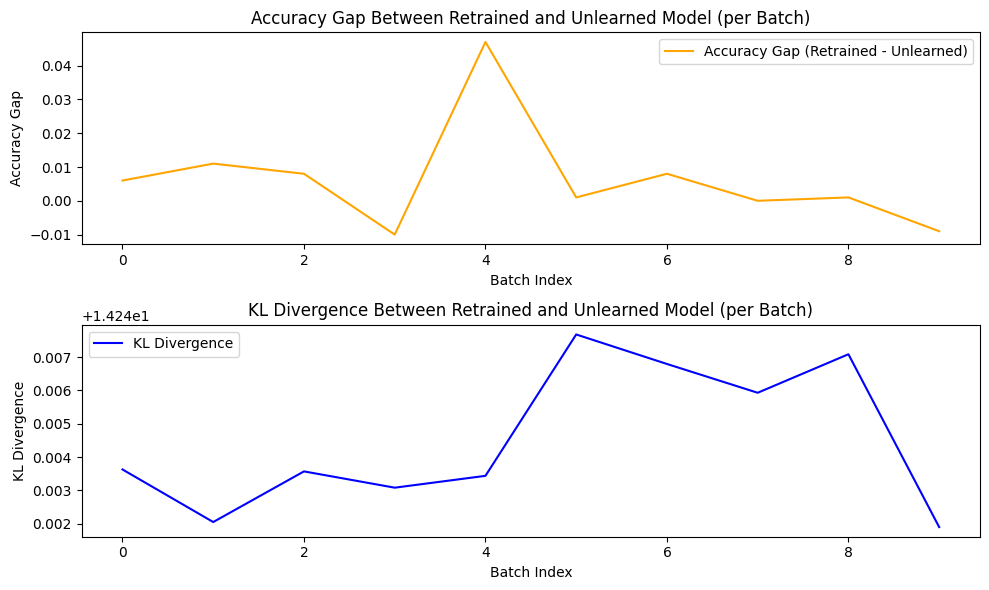

In [ ]:
# Assuming `unlearned_model`, `retrained_model`, and `data_loader` are defined
plot_accuracy_gap_and_kl(unlearned_model, model_untrained, test_loader, device="cuda")
